In [1]:
import json
import os
import pickle
import sys

import numpy as np
from tqdm import tqdm

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler

from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d as smooth

nmb_rep = 100

outPath = os.path.join(dirs['out']['rsa'])
os.makedirs(outPath, exist_ok=True)

In [14]:
from typing import Union

def hist_equalize(matrix):
    matrix = np.copy(matrix)
    shape = matrix.shape
    matrix = matrix.reshape(-1)
    index = matrix.argsort()
    values = np.linspace(0, 1, index.shape[0])
    matrix[index] = values
    return matrix.reshape(shape)

def mkrdm(data):
    rdmat = 1 - cosine_similarity(data)
    return rdmat

def mkherdm(data):
    rdmat = 1 - cosine_similarity(data)
    return hist_equalize(rdmat)

def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

def rdmGranger(src: np.array, dst: np.array, n: int, k: int, mdl=Ridge) -> Union[np.array, dict]:
    assert((src.shape == dst.shape))
    
    triu = np.triu_indices(src.shape[0], k=1)

    unex_r, unex_f, norm_w = [], [], []
    for itime in np.arange(n+k, src.shape[2]):

        y = dst[triu[0], triu[1], itime]
        X_r = dst[triu[0], triu[1], (itime-n-k):(itime-k+1)]
        X_f = np.concatenate((
            dst[triu[0], triu[1], (itime-n-k):(itime-k+1)], 
            src[triu[0], triu[1], (itime-n-k):(itime-k+1)]), axis=-1)
        
        p_r = mdl.fit(X_r, y).predict(X_r)
        p_f = mdl.fit(X_f, y).predict(X_f)
        
        unex_r.append((y - p_r) @ (y - p_r).T)
        unex_f.append((y - p_f) @ (y - p_f).T)
        norm_w.append(np.linalg.norm(mdl.coef_))
    
    unex_r = np.array(unex_r)
    unex_f = np.array(unex_f)

    return np.log(unex_r/unex_f), {'reduced': unex_r, 'full': unex_f, 'norm_w': norm_w}

# Whole Intact Images

In [114]:
monkey = "both"
selectivity = "fast"

# grangerInfluence = {}
grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")
info = info[~noneIndex & sIndex].reset_index(drop=True)
itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
itc = itc[~noneIndex & sIndex]
pfc = pfc[~noneIndex & sIndex]

bl, ss, n, k = 50, 1, 50, 25

itcb = movavg(itc, bl, ss)
pfcb = movavg(pfc, bl, ss)
timb = np.arange(-200+bl/2, 700-bl/2, ss)

argsort = np.argsort(info.cat)
rdmItc = np.nan * np.ones([argsort.size, argsort.size, timb.size])
rdmPfc = np.nan * np.ones([argsort.size, argsort.size, timb.size])

for itime in range(timb.size):
    rdmItc[:,:,itime] = mkrdm(itcb[argsort, :, itime])
    rdmPfc[:,:,itime] = mkrdm(pfcb[argsort, :, itime])

In [122]:
# grangerInfluence = {'unex/a-i2p': [], 'unex/a-p2i': [], 'gi-i2p': [], 'gi-p2i': [], 'unex-i2p': []}
alpha = 25

mdl = Ridge(fit_intercept=True, positive=False, alpha=alpha)
pfc2itcGi, pfc2itc = rdmGranger(rdmPfc, rdmItc, n, k, mdl=mdl)
itc2pfcGi, itc2pfc = rdmGranger(rdmItc, rdmPfc, n, k, mdl=mdl)

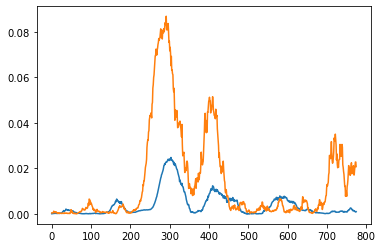

In [123]:
plt.plot(pfc2itcGi)
plt.plot(itc2pfcGi)

In [86]:
grangerInfluence = {'unex/a-i2p': [], 'unex/a-p2i': [], 'gi-i2p': [], 'gi-p2i': [], 'unex-i2p': []}

for alpha in tqdm([.1, 1, 10, 20, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 2000]):
    mdl = Ridge(fit_intercept=True, positive=False, alpha=alpha)
    pfc2itcGi, pfc2itc = rdmGranger(rdmPfc, rdmItc, n, k, mdl=mdl)
    itc2pfcGi, itc2pfc = rdmGranger(rdmItc, rdmPfc, n, k, mdl=mdl)

    grangerInfluence['unex/a-i2p'].append(itc2pfc['reduced'] / itc2pfc['norm_w'])
    grangerInfluence['unex/a-p2i'].append(pfc2itc['reduced'] / pfc2itc['norm_w'])
    grangerInfluence['gi-i2p'].append(itc2pfcGi)
    grangerInfluence['gi-p2i'].append(pfc2itcGi)
    grangerInfluence['unex-i2p'].append(itc2pfc['reduced'])

100%|██████████| 14/14 [01:49<00:00,  7.81s/it]


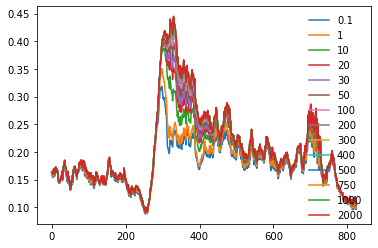

In [91]:
plt.plot(np.array(grangerInfluence['unex-i2p']).T);
plt.legend([.1, 1, 10, 20, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 2000], frameon=False)

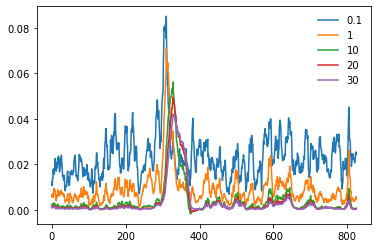

In [92]:
plt.plot(np.array(grangerInfluence['gi-p2i']).T[:, :5]);
plt.legend([.1, 1, 10, 20, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 2000][:5], frameon=False)

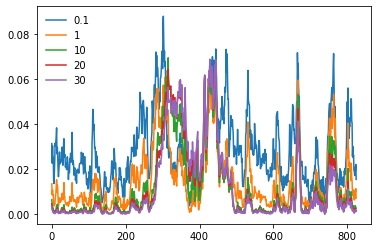

In [97]:
plt.plot(np.array(grangerInfluence['gi-i2p']).T[:, :5]);
plt.legend([.1, 1, 10, 20, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 2000][:5], frameon=False)

0

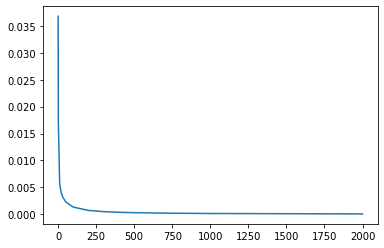

In [98]:
plt.plot([.1, 1, 10, 20, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 2000], \
    np.array(grangerInfluence['gi-p2i']).T[300, :] - np.array(grangerInfluence['gi-p2i']).T[100, :])
np.argmax(np.array(grangerInfluence['gi-p2i']).T[300, :] - np.array(grangerInfluence['gi-p2i']).T[100, :])

0

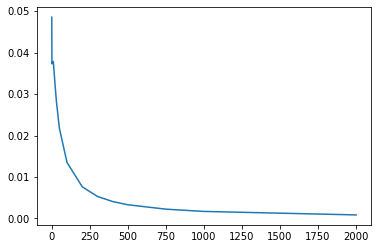

In [96]:
plt.plot([.1, 1, 10, 20, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 2000], \
    np.array(grangerInfluence['gi-i2p']).T[300, :] - np.array(grangerInfluence['gi-i2p']).T[100, :]);
np.argmax(np.array(grangerInfluence['gi-i2p']).T[300, :] - np.array(grangerInfluence['gi-i2p']).T[100, :])

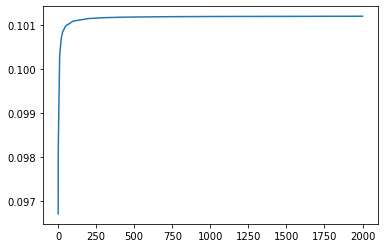

In [107]:
plt.plot([.1, 1, 10, 20, 30, 50, 100, 200, 300, 400, 500, 750, 1000, 2000], \
    np.array(grangerInfluence['unex-i2p'])[:, 250]);

In [68]:
grangerInfluence2 = {'unex/a-i2p': [], 'unex/a-p2i': [], 'gi-i2p': [], 'gi-p2i': [], 'unex-i2p': []}

for alpha in tqdm(np.arange(10, 50, step=2)):
    mdl = Ridge(fit_intercept=True, positive=False, alpha=alpha)
    pfc2itcGi, pfc2itc = rdmGranger(rdmPfc, rdmItc, n, k, mdl=mdl)
    itc2pfcGi, itc2pfc = rdmGranger(rdmItc, rdmPfc, n, k, mdl=mdl)

    grangerInfluence2['unex/a-i2p'].append(itc2pfc['reduced'] / itc2pfc['norm_w'])
    grangerInfluence2['unex/a-p2i'].append(pfc2itc['reduced'] / pfc2itc['norm_w'])
    grangerInfluence2['gi-i2p'].append(itc2pfcGi)
    grangerInfluence2['gi-p2i'].append(pfc2itcGi)
    grangerInfluence2['unex-i2p'].append(itc2pfc['reduced'])

100%|██████████| 20/20 [04:21<00:00, 13.10s/it]


34

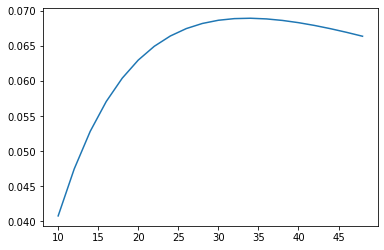

In [116]:
plt.plot(np.arange(10, 50, step=2), \
    np.array(grangerInfluence2['gi-i2p']).T[300, :] - np.array(grangerInfluence2['gi-i2p']).T[100, :])
np.arange(10, 50, step=2)[np.argmax(np.array(grangerInfluence2['gi-i2p']).T[300, :] - np.array(grangerInfluence2['gi-i2p']).T[100, :])]

28

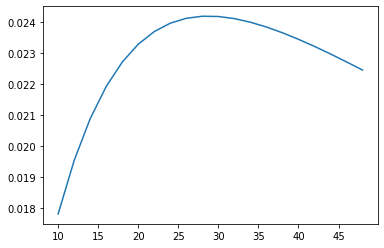

In [117]:
plt.plot(np.arange(10, 50, step=2), \
    np.array(grangerInfluence2['gi-p2i']).T[300, :] - np.array(grangerInfluence2['gi-p2i']).T[100, :]);
np.arange(10, 50, step=2)[np.argmax(np.array(grangerInfluence2['gi-p2i']).T[300, :] - np.array(grangerInfluence2['gi-p2i']).T[100, :])]

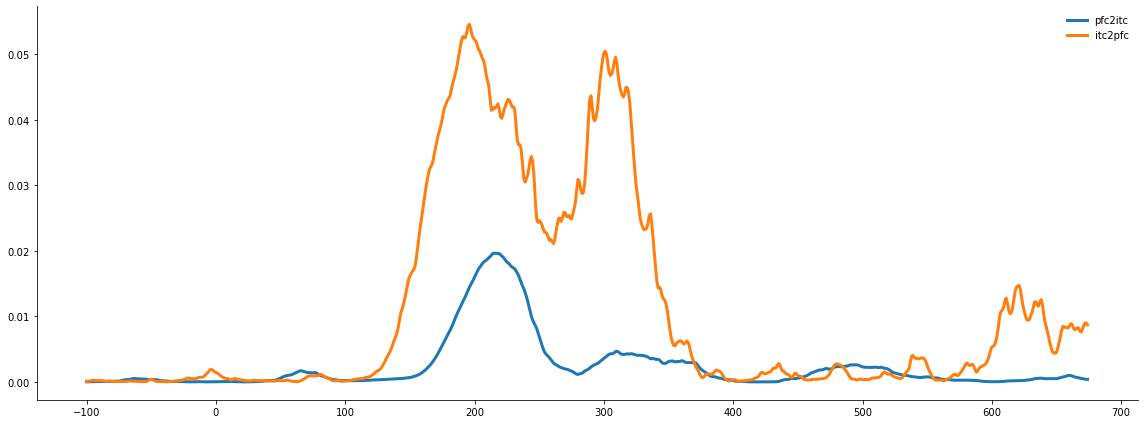

In [7]:
timp = timb[n+k:]
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(timp, smooth(grangerInfluence['pfc2itc'], 1), lw=3)
ax.plot(timp, smooth(grangerInfluence['itc2pfc'], 1), lw=3)

ax.legend(["pfc2itc", "itc2pfc"], frameon=False)

sns.despine()
fig.tight_layout()

In [ ]:
timp = timb[n+k:]
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(timp, smooth(pfc2itc['full'], 1), lw=3)
axs[0].plot(timp, smooth(pfc2itc['reduced'], 1), lw=3)

axs[1].plot(timp, smooth(itc2pfc['full'], 1), lw=3)
axs[1].plot(timp, smooth(itc2pfc['reduced'], 1), lw=3)

for ax in axs:
    axs[0].legend(["full", "reduced"])

sns.despine()
fig.tight_layout()

In [13]:
monkey = "both"
selectivity = "fast"

grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
# grangerInfluence = {}
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")
info = info[~noneIndex & sIndex].reset_index(drop=True)
itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
itc = itc[~noneIndex & sIndex]
pfc = pfc[~noneIndex & sIndex]

for bl in tqdm([10, 25, 50, 100]):
    k = int(bl / 2)
    ss = 1
    n = 50

    itcb = movavg(itc, bl, ss)
    pfcb = movavg(pfc, bl, ss)
    timb = np.arange(-200+bl/2, 700-bl/2, ss)

    argsort = np.argsort(info.cat)
    rdmItc = np.nan * np.ones([argsort.size, argsort.size, timb.size])
    rdmPfc = np.nan * np.ones([argsort.size, argsort.size, timb.size])

    for itime in range(timb.size):
        rdmItc[:,:,itime] = mkrdm(itcb[argsort, :, itime])
        rdmPfc[:,:,itime] = mkrdm(pfcb[argsort, :, itime])

    # mdl = LinearRegression(fit_intercept=True, positive=False)
    mdl = Ridge(fit_intercept=True, positive=False, alpha=100)
    pfc2itcGi, pfc2itc = rdmGranger(rdmPfc, rdmItc, n, k, mdl=mdl)
    itc2pfcGi, itc2pfc = rdmGranger(rdmItc, rdmPfc, n, k, mdl=mdl)

    grangerInfluence['pfc2itc'][bl] = pfc2itcGi
    grangerInfluence['itc2pfc'][bl] = itc2pfcGi

100%|██████████| 4/4 [01:30<00:00, 22.68s/it]


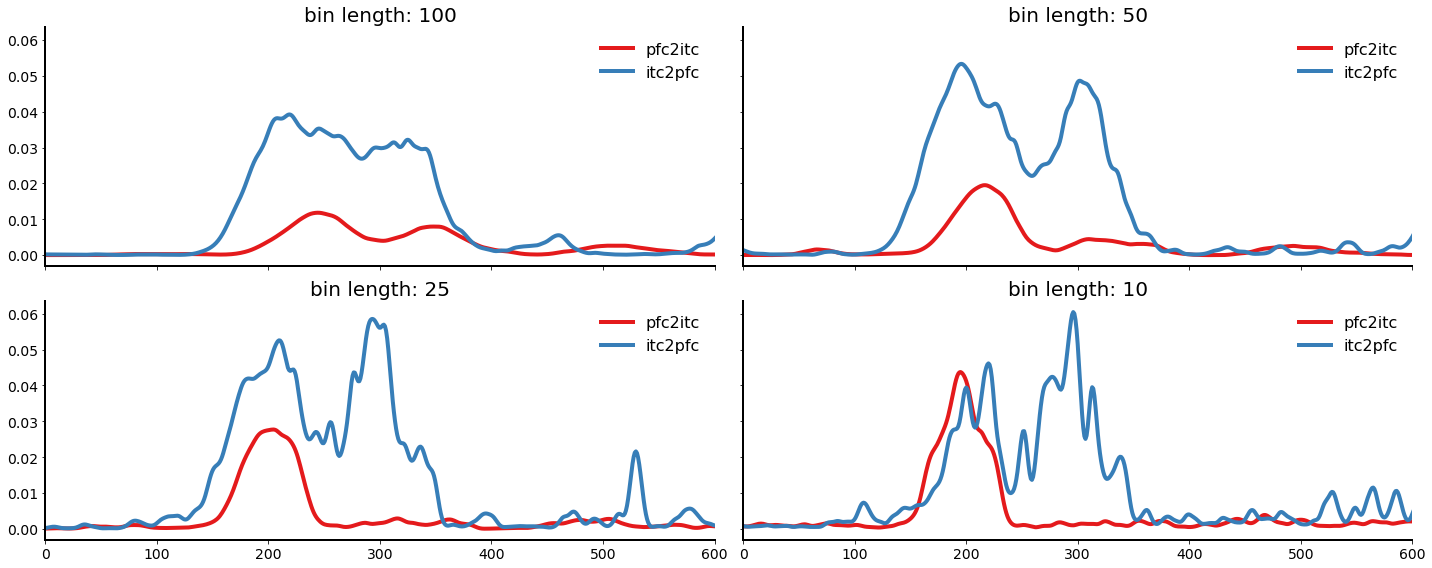

In [71]:
sns.set_palette("Set1")

fig, axs = plt.subplots(2, 2, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.flatten()
bls = grangerInfluence['pfc2itc'].keys()
bls = np.flip(list(bls))

for bl, ax in zip(bls, axs):
    k = int(bl / 2)
    ss = 1
    n = 50

    timb = np.arange(-200+bl/2, 700-bl/2, ss)
    timp = timb[n+k:]

    ax.plot(timp, smooth(grangerInfluence['pfc2itc'][bl], 3), lw=4, label='pfc2itc')
    ax.plot(timp, smooth(grangerInfluence['itc2pfc'][bl], 3), lw=4, label='itc2pfc')
    # ax.axvline()

    ax.legend(frameon=False, fontsize=16)
    ax.set_xlim(0, 600)
    ax.set_title(f"bin length: {bl}", fontsize=20)

    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax.spines.values(), linewidth=2)

sns.despine()
fig.tight_layout()

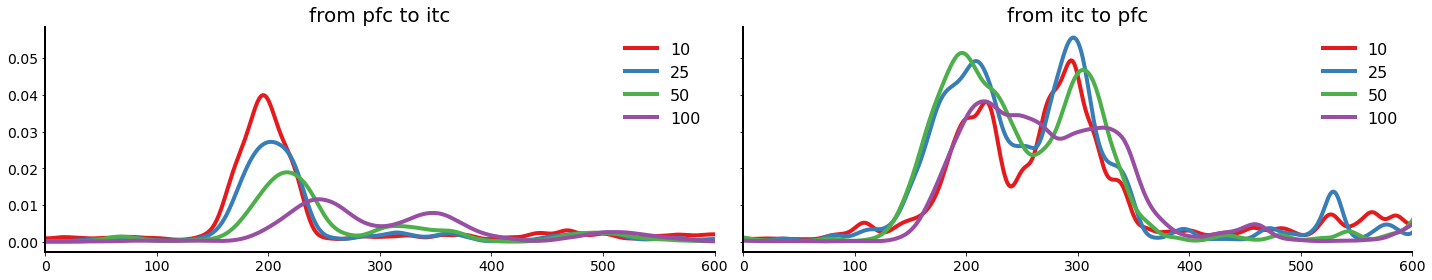

In [97]:
sns.set_palette("Set1")

fig, axs = plt.subplots(1, 2, figsize=(20, 4), sharex=True, sharey=True)
axs = axs.flatten()
bls = grangerInfluence['pfc2itc'].keys()
bls = list(bls)

for bl in bls:
    k = int(bl / 2)
    ss = 1
    n = 50

    timb = np.arange(-200+bl/2, 700-bl/2, ss)
    timp = timb[n+k:]

    axs[0].plot(timp, smooth(grangerInfluence['pfc2itc'][bl], 7), lw=4, label=bl)
    axs[1].plot(timp, smooth(grangerInfluence['itc2pfc'][bl], 7), lw=4, label=bl)
    # ax.axvline()

for ax in axs:
    ax.legend(frameon=False, fontsize=16)
    ax.set_xlim(0, 600)

    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax.spines.values(), linewidth=2)

axs[0].set_title("from pfc to itc", fontsize=20)
axs[1].set_title("from itc to pfc", fontsize=20)

sns.despine()
fig.tight_layout()

# Bootstrap

In [147]:
def rdmGrangerBt(src: np.array, dst: np.array, n: int, k: int, mdl=Ridge) -> Union[np.array, dict]:
    assert((src.shape == dst.shape))
    
    GI = []
    upper_index = np.triu_indices(src.shape[0], k=1)
    for bt in tqdm(range(100)):
        triu = np.random.choice(a=np.arange(upper_index[0].size), size=upper_index[0].size, replace=True)
        triu = (upper_index[0][triu], upper_index[1][triu])

        unex_r, unex_f = [], []
        for itime in np.arange(n+k, src.shape[2]):

            y = dst[triu[0], triu[1], itime]
            X_r = dst[triu[0], triu[1], (itime-n-k):(itime-k+1)]
            X_f = np.concatenate((
                dst[triu[0], triu[1], (itime-n-k):(itime-k+1)], 
                src[triu[0], triu[1], (itime-n-k):(itime-k+1)]), axis=-1)
            
            p_r = mdl.fit(X_r, y).predict(X_r)
            p_f = mdl.fit(X_f, y).predict(X_f)
            
            unex_r.append((y - p_r) @ (y - p_r).T)
            unex_f.append((y - p_f) @ (y - p_f).T)
        
        unex_r = np.array(unex_r)
        unex_f = np.array(unex_f)

        GI.append(np.log(unex_r/unex_f))

    return np.array(GI)

In [125]:
monkey = "both"
selectivity = "fast"

# grangerInfluence = {}
grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")
info = info[~noneIndex & sIndex].reset_index(drop=True)
itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
itc = itc[~noneIndex & sIndex]
pfc = pfc[~noneIndex & sIndex]

bl, ss, n, k = 50, 1, 50, 25

itcb = movavg(itc, bl, ss)
pfcb = movavg(pfc, bl, ss)
timb = np.arange(-200+bl/2, 700-bl/2, ss)

argsort = np.argsort(info.cat)
rdmItc = np.nan * np.ones([argsort.size, argsort.size, timb.size])
rdmPfc = np.nan * np.ones([argsort.size, argsort.size, timb.size])

for itime in range(timb.size):
    rdmItc[:,:,itime] = mkrdm(itcb[argsort, :, itime])
    rdmPfc[:,:,itime] = mkrdm(pfcb[argsort, :, itime])

In [149]:
# grangerInfluence = {'unex/a-i2p': [], 'unex/a-p2i': [], 'gi-i2p': [], 'gi-p2i': [], 'unex-i2p': []}
alpha = 30

mdl = Ridge(fit_intercept=True, positive=False, alpha=alpha)
pfc2itcGi = rdmGrangerBt(rdmPfc, rdmItc, n, k, mdl=mdl)
itc2pfcGi  = rdmGrangerBt(rdmItc, rdmPfc, n, k, mdl=mdl)

100%|██████████| 100/100 [11:53<00:00,  7.14s/it]


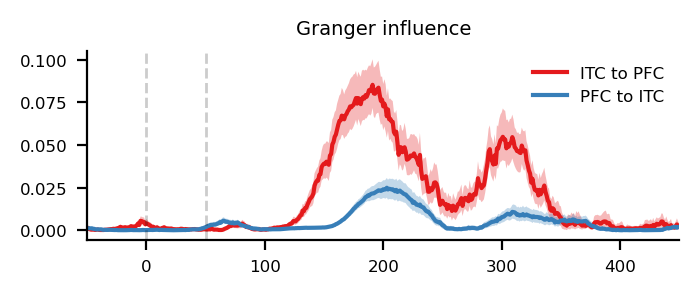

In [176]:
sns.set_palette('Set1')

timp = timb[n+k:]

cm = 1 / 2.54
fig, axs = plt.subplots(1, 1, figsize=(9*cm, 4*cm), dpi=200)

axs.plot(timp, itc2pfcGi.mean(0), label='ITC to PFC')
axs.fill_between(timp, np.percentile(itc2pfcGi, q=5, axis=0), np.percentile(itc2pfcGi, q=95, axis=0), alpha=.3, label='_nolegend_')
axs.plot(timp, pfc2itcGi.mean(0), label='PFC to ITC')
axs.fill_between(timp, np.percentile(pfc2itcGi, q=5, axis=0), np.percentile(pfc2itcGi, q=95, axis=0), alpha=.3, label='_nolegend_')
axs.set_xlim(-50, 450)

axs.axvline(0, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
axs.axvline(50, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
axs.tick_params(axis='both', which='major', labelsize=6)
axs.set_title('Granger influence', fontsize=7)
axs.legend(frameon=False, fontsize=6)

sns.despine()
fig.tight_layout()

plt.savefig('granger-influence.pdf')

In [169]:
for var, name in zip([pfc2itcGi, itc2pfcGi], ['i2c', 'p2i']):
    with open(os.path.join('.', f'c-gi-{name}.pickle'), 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Temporary Snippets

In [ ]:
src = rdmItc
dst = rdmPfc

# dst = rdmItc
# src = rdmPfc

from sklearn.metrics import explained_variance_score

# src = (src - src.mean()) / src.std()
# dst = (dst - dst.mean()) / dst.std()

i = np.triu_indices(src.shape[0], k=1)

n, k = 100, 25

reducedU, fullU = [], []
for itime in np.arange(n+k, src.shape[2]):

    Y = dst[i[0], i[1], itime]
    X = dst[i[0], i[1], (itime-n-k):(itime-k+1)]
    # X = StandardScaler().fit_transform(X)
    # Y = StandardScaler().fit_transform(Y.reshape(-1, 1)).flatten()
    mdl = Ridge(fit_intercept=True, positive=True, alpha=10)
    mdl = mdl.fit(X, Y)
    # SST = Y.var() * Y.size
    SST = (Y - Y.mean()) @ (Y - Y.mean()).T
    SSR = (Y - mdl.predict(X)) @ (Y - mdl.predict(X)).T
    SSE = SST - SSR
    # print(SST, SSR, SSE)
    # reducedU.append(explained_variance_score(Y, mdl.predict(X)))
    reducedU.append(SSR)
    # reducedR2.append(mdl.score(X, Y))

    X = np.concatenate((dst[i[0], i[1], (itime-n-k):(itime-k+1)], src[i[0], i[1], (itime-n-k):(itime-k+1)]), axis=-1)
    # # X = StandardScaler().fit_transform(X)
    # mdl = Ridge(fit_intercept=True, positive=False, alpha=2)
    mdl = mdl.fit(X, Y)
    # # SST = Y.var() * Y.size
    SSR = (Y - mdl.predict(X)) @ (Y - mdl.predict(X)).T
    SSE = SST - SSR
    # print(SST, SSR, SSE)
    fullU.append(SSR)
    # fullU.append(explained_variance_score(Y, mdl.predict(X)))
    # break
fullU = np.array(fullU)
reducedU = np.array(reducedU)


In [ ]:
timp = timb[n+k:]

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(timp, reducedU - reducedU[timp < 0].mean())
axs[0].plot(timp, fullU - fullU[timp < 0].mean())

# axs[1].plot(timp, np.log((reducedU - reducedU[timp < 0].mean()) / (fullU - fullU[timp < 0].mean())))
axs[1].plot(timp, np.log(reducedU / fullU))



In [ ]:
timp = timb[n+k:]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(timp, smooth(grangerInfluence['pfc2itc'], 1), lw=3)
ax.plot(timp, smooth(grangerInfluence['itc2pfc'], 1), lw=3)

sns.despine()
fig.tight_layout()

# Artificial Objects

In [150]:
monkey = "both"
selectivity = "fast"

grangerInfluence = {}

categories = ['fac', 'bod', 'nat', 'art', 'all']
for c in categories:

    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]
    sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
    noneIndex = (info.cat == "none")
    if c == 'all':
        categoryIndex = (np.ones((len(info), 1))==1).flatten()
    else:
        categoryIndex = info[c].to_numpy()
    info = info[~noneIndex & sIndex & categoryIndex].reset_index(drop=True)
    itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
    pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
    itc = itc[~noneIndex & sIndex & categoryIndex]
    pfc = pfc[~noneIndex & sIndex & categoryIndex]

    bl = 50
    k = int(bl / 2)
    # k = 50
    ss = 1
    n = 50

    itcb = movavg(itc, bl, ss)
    pfcb = movavg(pfc, bl, ss)
    timb = np.arange(-200+bl/2, 700-bl/2, ss)

    argsort = np.argsort(info.cat)
    rdmItc = np.nan * np.ones([argsort.size, argsort.size, timb.size])
    rdmPfc = np.nan * np.ones([argsort.size, argsort.size, timb.size])

    for itime in range(timb.size):
        rdmItc[:,:,itime] = mkrdm(itcb[argsort, :, itime])
        rdmPfc[:,:,itime] = mkrdm(pfcb[argsort, :, itime])


    mdl = Ridge(fit_intercept=True, positive=False, alpha=1)
    
    # pfc2itcGi, pfc2itc = rdmGranger(rdmPfc, rdmItc, n, k, mdl=mdl)
    # grangerInfluence[c] = pfc2itcGi

    itc2pfcGi, itc2pfc = rdmGranger(rdmItc, rdmPfc, n, k, mdl=mdl)
    grangerInfluence[c] = itc2pfcGi

# timp = timb[n+k:]
# fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=120)

# ax.plot(timp, smooth(grangerInfluence['pfc2itc'], 1), lw=3)
# ax.plot(timp, smooth(grangerInfluence['itc2pfc'], 1), lw=3)

# ax.legend(["pfc2itc", "itc2pfc"], frameon=False)

# sns.despine()
# fig.tight_layout()

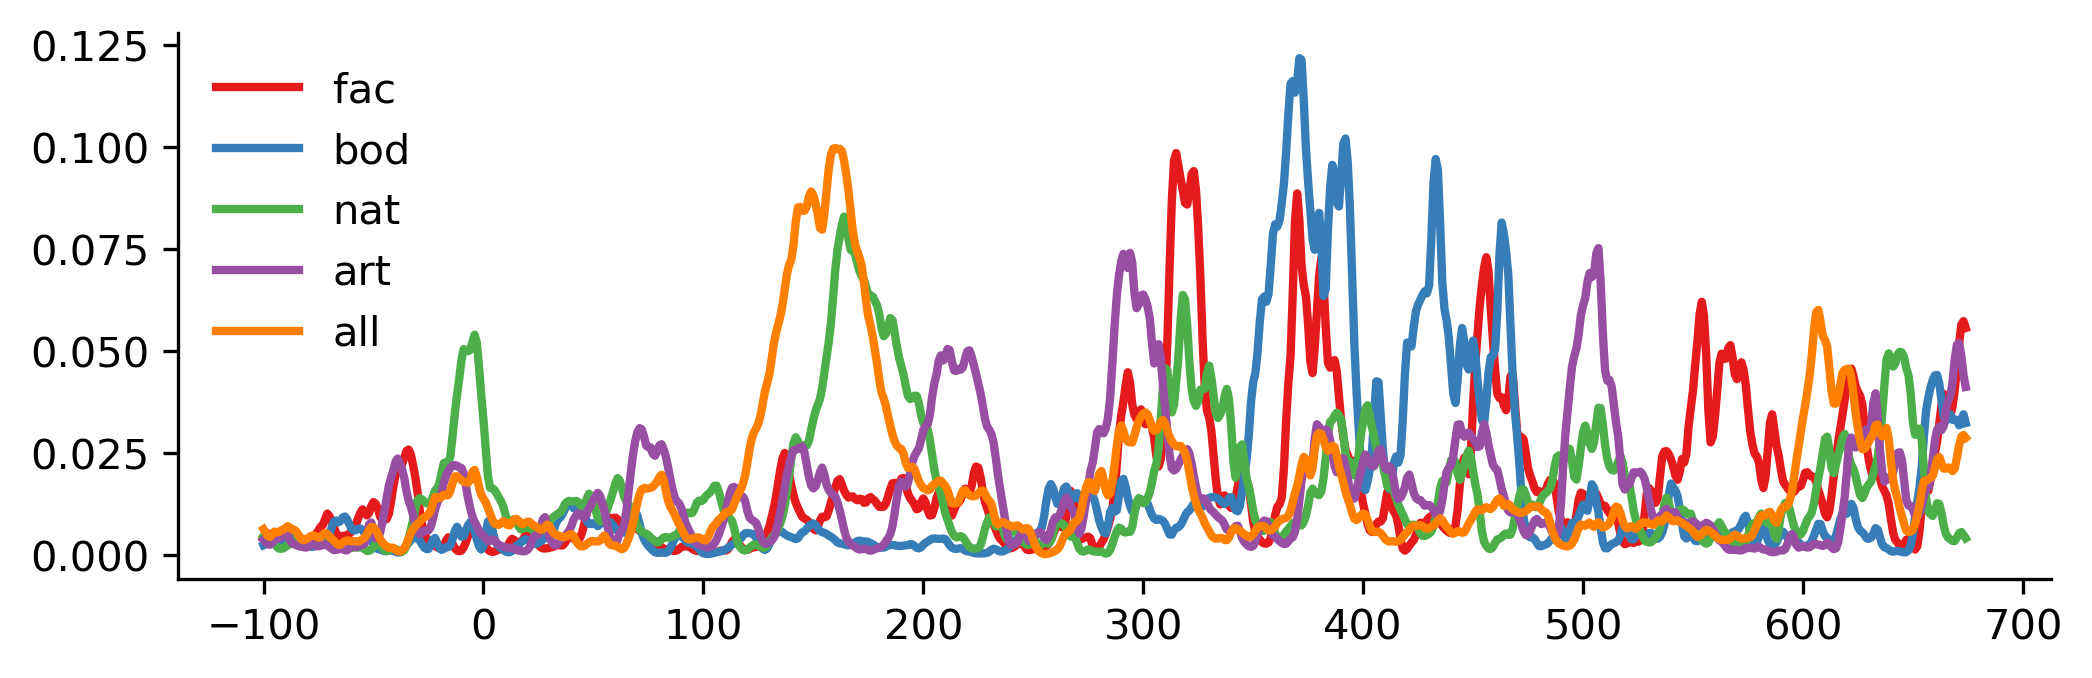

In [151]:
mm = 1 / 2.54
timp = timb[n+k:]
fig, ax = plt.subplots(1, 1, figsize=(18*mm, 6*mm), dpi=300)

for c in categories:
    # if c=='all':
    #     continue
    ax.plot(timp, smooth(grangerInfluence[c], 1), lw=2, label=c)
# ax.plot(timp, smooth(grangerInfluence['itc2pfc'], 1), lw=3)

ax.legend(frameon=False)

sns.despine()
fig.tight_layout()

In [112]:
grangerInfluence.keys()

dict_keys(['art'])

# Different Spatial Frequency

In [ ]:
monkey = "both"
selectivity = "fast"

grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
for sfr in ["BH", "BI", "BL"]:
    with open("../utils/info.pkl", "rb") as handler:
        info = pickle.load(handler)
    info = info[:165]
    sIndex = (info.sfr == sfr)
    noneIndex = (info.cat == "none")
    info = info[~noneIndex & sIndex].reset_index(drop=True)
    itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
    pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
    itc = itc[~noneIndex & sIndex]
    pfc = pfc[~noneIndex & sIndex]

    bl, ss = 50, 1
    n, k = 50, 50

    itcb = movavg(itc, bl, ss)
    pfcb = movavg(pfc, bl, ss)
    timb = np.arange(-200+bl/2, 700-bl/2, ss)

    argsort = np.argsort(info.cat)
    rdmItc = np.nan * np.ones([argsort.size, argsort.size, timb.size])
    rdmPfc = np.nan * np.ones([argsort.size, argsort.size, timb.size])

    for itime in range(timb.size):
        rdmItc[:,:,itime] = mkrdm(itcb[argsort, :, itime])
        rdmPfc[:,:,itime] = mkrdm(pfcb[argsort, :, itime])

    # mdl = LinearRegression(fit_intercept=True, positive=False)
    mdl = Ridge(fit_intercept=True, positive=False, alpha=100)
    pfc2itcGi, pfc2itc = rdmGranger(rdmPfc, rdmItc, n, k, mdl=mdl)
    itc2pfcGi, itc2pfc = rdmGranger(rdmItc, rdmPfc, n, k, mdl=mdl)

    grangerInfluence['pfc2itc'][sfr] = pfc2itcGi
    grangerInfluence['itc2pfc'][sfr] = itc2pfcGi

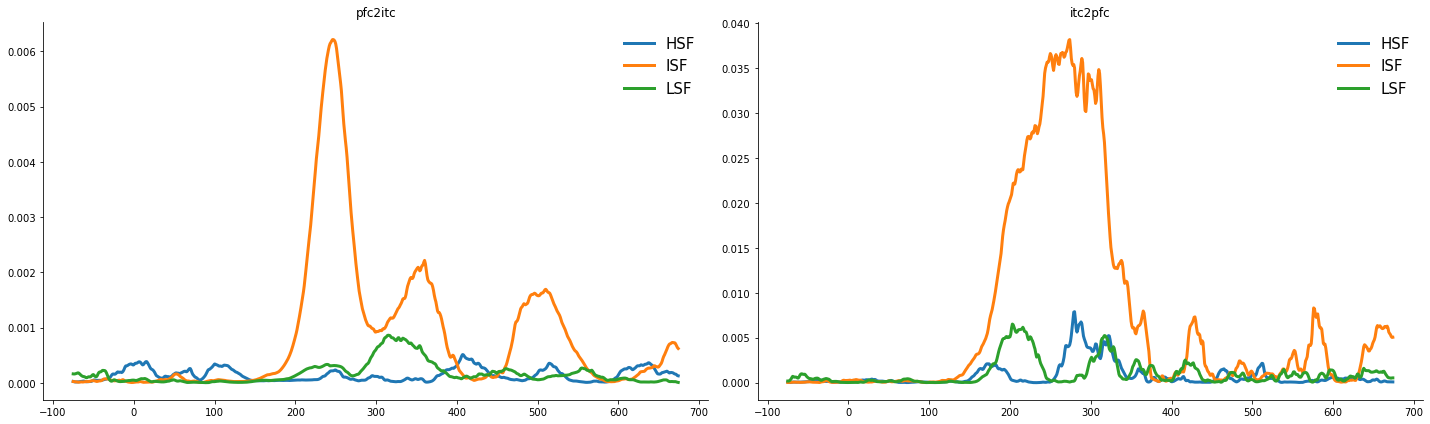

In [ ]:
timp = timb[n+k:]
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for sfr in ["BH", "BI", "BL"]:
    axs[0].plot(timp, smooth(grangerInfluence['pfc2itc'][sfr], 1), lw=3)
    axs[1].plot(timp, smooth(grangerInfluence['itc2pfc'][sfr], 1), lw=3)

for ax, title in zip(axs, ["pfc2itc", "itc2pfc"]):
    ax.legend(["HSF", "ISF", "LSF"], frameon=False, fontsize=15)
    ax.set_title(title)
    # ax.set_xlim(-100, 200)
# axs[0].set_xlim(-100, 300)
# axs[1].set_xlim(0, 400)
sns.despine()
fig.tight_layout()